<a href="https://colab.research.google.com/github/Niloy-24/Transfer-Learning-Based-Classification-Of-Eye-Disease/blob/main/EfficientNetB7_NormalVsEyelid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
PATH = '/content/gdrive/MyDrive/Thesis/Data/NormalVsEyelid/'
train_dir = os.path.join(PATH, 'Train')
test_dir = os.path.join(PATH, 'Test')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1519 files belonging to 2 classes.


In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 363 files belonging to 2 classes.


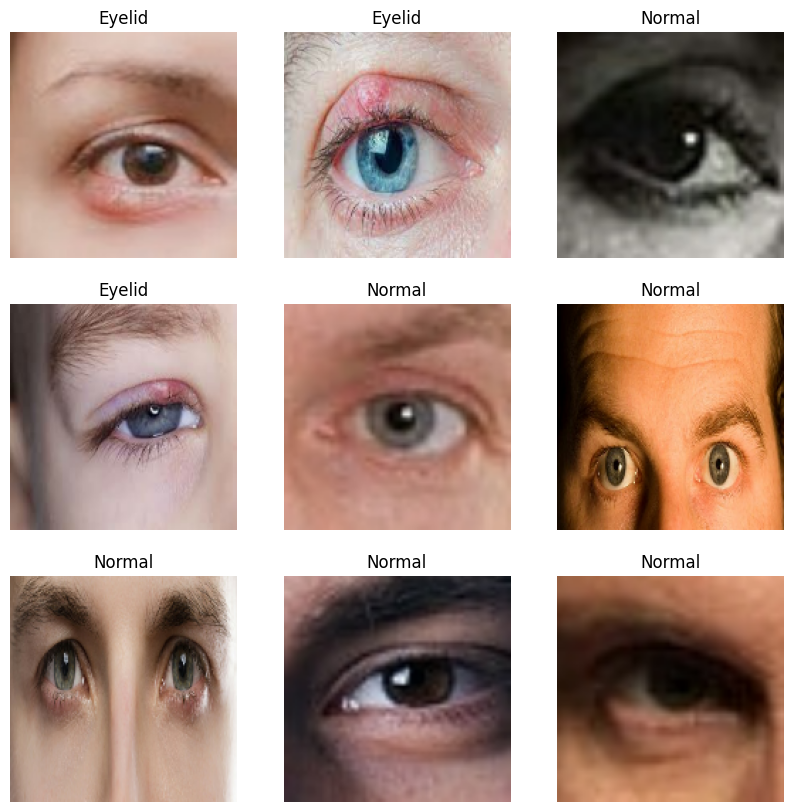

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
test_batches = tf.data.experimental.cardinality(test_dataset)
val_dataset = test_dataset.take(test_batches // 7)
val_dataset = test_dataset.skip(test_batches // 7)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 11
Number of test batches: 12


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

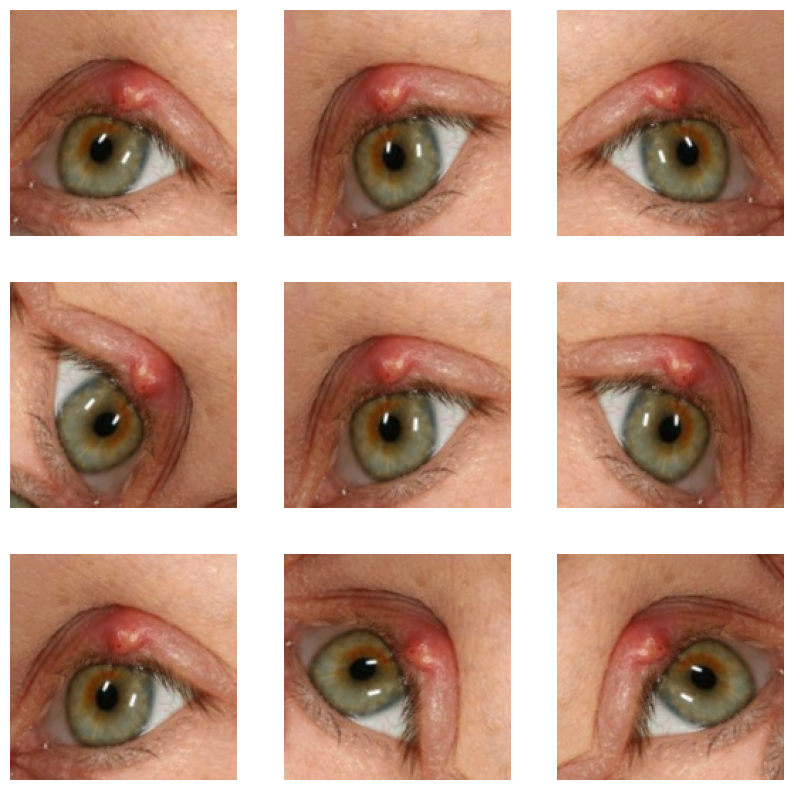

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.efficientnet.EfficientNetB7
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB7(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

258076736/258076736 [==============================] - 9s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2560)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 160, 160, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 160, 160, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 rescaling_2 (Rescaling)        (None, 160, 160, 3)  0           ['normalization[0][0

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2560)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
#x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 efficientnetb7 (Functional)  (None, 5, 5, 2560)       64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 1)                 2561      
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 50
loss0, accuracy0 = model.evaluate(val_dataset)

11/11 [==============================] - 134s 1s/step - loss: 2.0711 - accuracy: 0.4622


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.07
initial accuracy: 0.46


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

Epoch 1/50
48/48 [==============================] - 269s 5s/step - loss: 1.0313 - accuracy: 0.6294 - val_loss: 0.8987 - val_accuracy: 0.4924
Epoch 2/50
48/48 [==============================] - 13s 268ms/step - loss: 0.7305 - accuracy: 0.7209 - val_loss: 0.7483 - val_accuracy: 0.6012
Epoch 3/50
48/48 [==============================] - 13s 268ms/step - loss: 0.6297 - accuracy: 0.7551 - val_loss: 0.8881 - val_accuracy: 0.5952
Epoch 4/50
48/48 [==============================] - 15s 309ms/step - loss: 0.6046 - accuracy: 0.7742 - val_loss: 0.6920 - val_accuracy: 0.6465
Epoch 5/50
48/48 [==============================] - 13s 260ms/step - loss: 0.5040 - accuracy: 0.7768 - val_loss: 0.7812 - val_accuracy: 0.6284
Epoch 6/50
48/48 [==============================] - 13s 262ms/step - loss: 0.4810 - accuracy: 0.7966 - val_loss: 0.8128 - val_accuracy: 0.5952
Epoch 7/50
48/48 [==============================] - 13s 265ms/step - loss: 0.5483 - accuracy: 0.8104 - val_loss: 0.8738 - val_accuracy: 0.5921
E

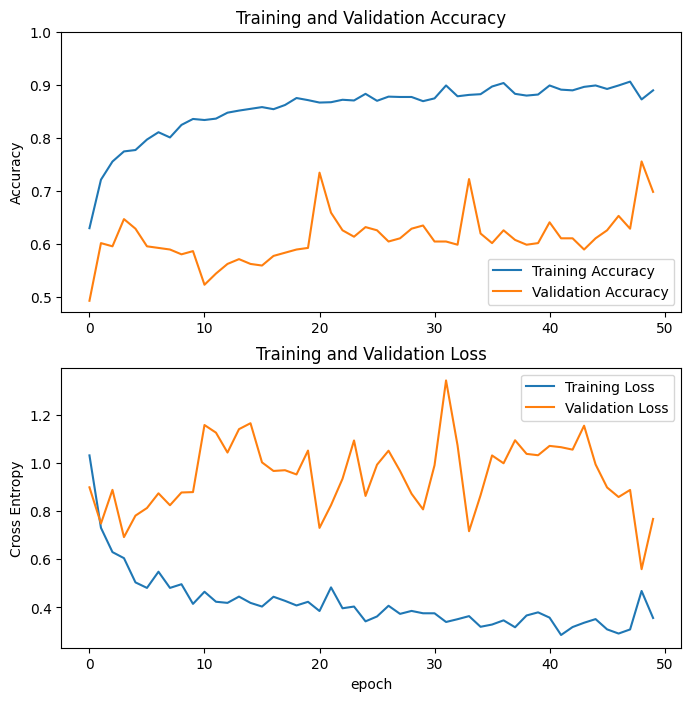

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[fine_tune_at:]:
  layer.trainable = True

Number of layers in the base model:  6


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 efficientnetb7 (Functional)  (None, 5, 5, 2560)       64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 1)                 2561      
                                                             

In [ ]:
len(model.trainable_variables)

711

In [ ]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)

Epoch 50/100
48/48 [==============================] - 183s 1s/step - loss: 0.3233 - accuracy: 0.9230 - val_loss: 1.1269 - val_accuracy: 0.6556
Epoch 51/100
48/48 [==============================] - 47s 982ms/step - loss: 0.1567 - accuracy: 0.9480 - val_loss: 0.6736 - val_accuracy: 0.8278
Epoch 52/100
48/48 [==============================] - 47s 984ms/step - loss: 0.1182 - accuracy: 0.9645 - val_loss: 0.7833 - val_accuracy: 0.8278
Epoch 53/100
48/48 [==============================] - 47s 981ms/step - loss: 0.0580 - accuracy: 0.9862 - val_loss: 0.4302 - val_accuracy: 0.9033
Epoch 54/100
48/48 [==============================] - 49s 1s/step - loss: 0.0419 - accuracy: 0.9895 - val_loss: 0.5182 - val_accuracy: 0.8973
Epoch 55/100
48/48 [==============================] - 47s 976ms/step - loss: 0.0284 - accuracy: 0.9921 - val_loss: 0.4148 - val_accuracy: 0.9154
Epoch 56/100
48/48 [==============================] - 47s 983ms/step - loss: 0.0451 - accuracy: 0.9928 - val_loss: 0.4290 - val_accurac

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

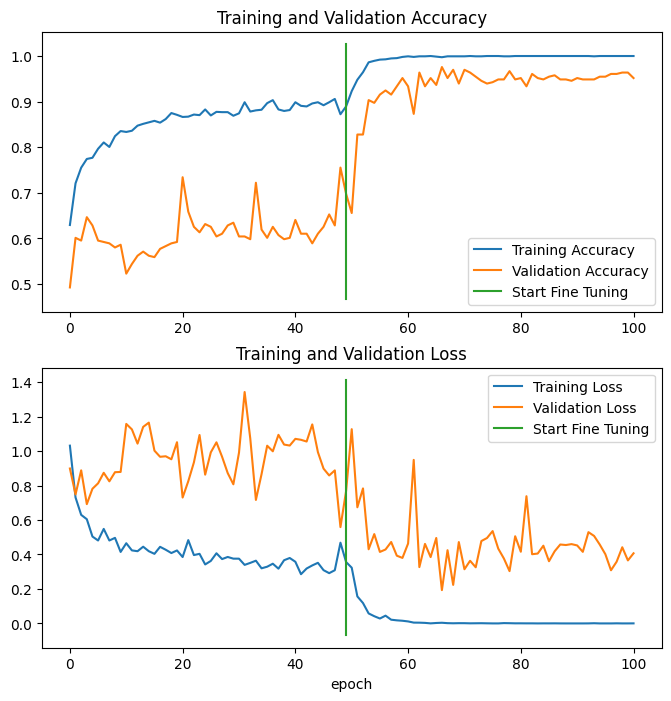

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

12/12 [==============================] - 3s 187ms/step - loss: 0.4554 - accuracy: 0.9504
Test accuracy : 0.9504132270812988


Predictions:
 [1 1 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0]
Labels:
 [1 1 0 1 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0]


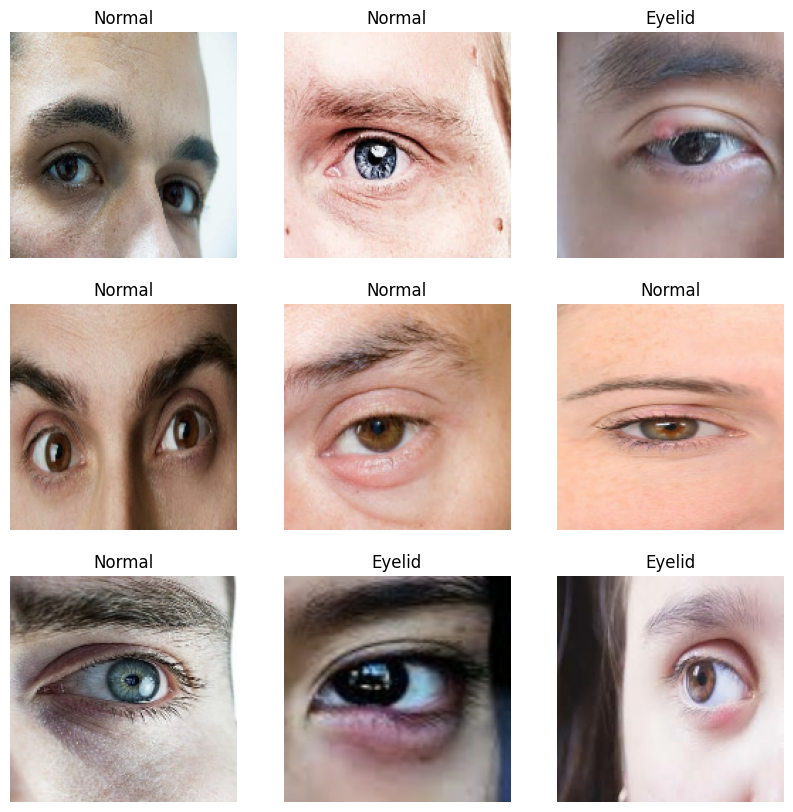

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
len(list(test_dataset))

12

In [ ]:
# True labels
true_labels = []
for batch in test_dataset:
    labels = batch[1]  # Assuming labels are the second component of each batch
    true_labels.extend(labels.numpy().tolist())

# Predicted labels
predicted_labels = model.predict(test_dataset)
predicted_labels = tf.nn.sigmoid(predicted_labels)
predicted_labels = tf.where(predicted_labels < 0.5, 0, 1)

# Calculate true positives, true negatives, false positives, and false negatives
true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(true_labels, 1), tf.equal(predicted_labels, 1)), tf.float32))
true_negatives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(true_labels, 0), tf.equal(predicted_labels, 0)), tf.float32))
false_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(true_labels, 0), tf.equal(predicted_labels, 1)), tf.float32))
false_negatives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(true_labels, 1), tf.equal(predicted_labels, 0)), tf.float32))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(tf.equal(true_labels, predicted_labels), tf.float32))

# Calculate True Positive Rate (TPR) or Recall
tpr = true_positives / (true_positives + false_negatives)

# Calculate True Negative Rate (TNR)
tnr = true_negatives / (true_negatives + false_positives)

# Calculate False Positive Rate (FPR)
fpr = false_positives / (false_positives + true_negatives)

# Calculate False Negative Rate (FNR)
fnr = false_negatives / (false_negatives + true_positives)

# Calculate Precision
precision = true_positives / (true_positives + false_positives)

# Calculate F1 Score
f1_score = 2 * ((precision * tpr) / (precision + tpr))

# Print the performance metrics

print("True Positive Rate (TPR) or Recall:", tpr.numpy())
print("True Negative Rate (TNR):", tnr.numpy())
print("False Positive Rate (FPR):", fpr.numpy())
print("False Negative Rate (FNR):", fnr.numpy())
print("Precision:", precision.numpy())
print("F1 Score:", f1_score.numpy())

12/12 [==============================] - 9s 184ms/step
True Positive Rate (TPR) or Recall: 0.5509642
True Negative Rate (TNR): 0.44903582
False Positive Rate (FPR): 0.5509642
False Negative Rate (FNR): 0.44903582
Precision: 0.5509642
F1 Score: 0.5509642


In [ ]:
predicted_labels

<tf.Tensor: shape=(363, 1), dtype=int32, numpy=
array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
    

In [ ]:
true_labels

[0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()

# Calculate true positive rate (TPR) or recall
tpr = tp / (tp + fn)
print("True Positive Rate (TPR):", tpr)

# Calculate true negative rate (TNR)
tnr = tn / (tn + fp)
print("True Negative Rate (TNR):", tnr)

# Calculate false positive rate (FPR)
fpr = fp / (fp + tn)
print("False Positive Rate (FPR):", fpr)

# Calculate false negative rate (FNR)
fnr = fn / (fn + tp)
print("False Negative Rate (FNR):", fnr)

# Calculate precision
precision = precision_score(true_labels, predicted_labels)
print("Precision:", precision)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels)
print("F1 Score:", f1)


True Positive Rate (TPR): 0.52
True Negative Rate (TNR): 0.4110429447852761
False Positive Rate (FPR): 0.588957055214724
False Negative Rate (FNR): 0.48
Precision: 0.52
F1 Score: 0.52


In [ ]:
from tensorflow.keras.models import load_model

model.save('/content/gdrive/MyDrive/Saved_Model/EfficientNetB7_NormalVsEyelid.h5')

TypeError: ignored